In [20]:
import pandas as pd
import sqlite3

repo_dir = "Your Path Here"
conn = sqlite3.connect(repo_dir)
curs = conn.cursor()
pd.set_option('display.max_columns', None)

qry = """WITH prelim AS (
    SELECT
        dir.dealid,
        dir.investorfundid,
        dir.InvestorInvestmentAmount,
        dir.NumberOfSharesAcquired AS NumberOfSharesAcquired_DIR,
        d.NumberOfSharesAcquired AS NumberOfSharesAcquired_D,
        d.PercentAcquired,
        d.DealSize,
        d.SeriesOfStock,
        d.DealDate,
        d.CompanyID,
        d.DealID
    FROM
        DealInvestorRelation dir
    LEFT JOIN
        Deal d ON dir.dealid = d.DealID
),
joined AS (
    SELECT
        p.dealid,
        p.investorfundid,
        p.InvestorInvestmentAmount,
        p.NumberOfSharesAcquired_DIR,
        p.NumberOfSharesAcquired_D,
        p.PercentAcquired,
        p.DealSize,
        p.DealDate,
        p.CompanyID,
        p.DealID,
        f.FundCountry,
        CASE
            WHEN p.SeriesOfStock LIKE '%Seed%' THEN 'Seed'
            WHEN p.SeriesOfStock LIKE '%A%' THEN 'A'
            WHEN p.SeriesOfStock LIKE '%B%' THEN 'B'
            WHEN p.SeriesOfStock LIKE '%C%' THEN 'C'
            WHEN p.SeriesOfStock LIKE '%D%' THEN 'D'
            WHEN p.SeriesOfStock LIKE '%E%' THEN 'E'
            WHEN p.SeriesOfStock LIKE '%F%' THEN 'F'
            WHEN p.SeriesOfStock LIKE '%G%' THEN 'G'
            ELSE 'Null'
        END AS SeedType
    FROM
        prelim p
    LEFT JOIN
        Fund f ON p.investorfundid = f.fundid
),
seed_investment_info AS (
    SELECT
        *,
        CASE
            WHEN InvestorInvestmentAmount IS NOT NULL THEN 1
            ELSE 0
        END AS HasInvestedAmount
    FROM
        joined
),
ranked_investments AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY investorfundid, CompanyID ORDER BY DealDate) AS Rank
    FROM
        seed_investment_info
),
company_info AS (
    SELECT
        ri.*,
        c.companyid,
        c.GrowthRate,
        c.HQCountry
    FROM
        ranked_investments ri
    JOIN
        Company c ON ri.CompanyID = c.companyid
)
SELECT
    ci.*
FROM
    company_info ci
WHERE
    ci.InvestorInvestmentAmount IS NOT NULL
    AND ci.FundCountry = 'United States';"""
# query sample of interest

df = pd.read_sql_query(qry, conn)
df['DealDate'] = pd.to_datetime(df['DealDate'])
df.rename(columns={'NumberOfSharesAcquired': 'NumberOfSharesAcquired_DIR'}, inplace=True)

In [21]:
# calculate fund pa and total shares
df["TotalShares"] = (df["NumberOfSharesAcquired_D"]/df["PercentAcquired"]) * 100
df["FundPA"] = (df["NumberOfSharesAcquired_DIR"]/df["TotalShares"]) * 100
df["PredictedFundPA_0"] = (df["InvestorInvestmentAmount"]/df["DealSize"]) * df["PercentAcquired"]
print(df["SeedType"].unique())

['Null' 'A' 'B' 'C' 'D' 'F' 'Seed' 'E' 'G']


In [24]:
# get distribution of percent acquired
distribution = df["PercentAcquired"].describe()
print(distribution)

count    15315.000000
mean        24.121277
std         15.498438
min          0.010000
25%         10.815000
50%         22.630000
75%         33.330000
max         94.340000
Name: PercentAcquired, dtype: float64


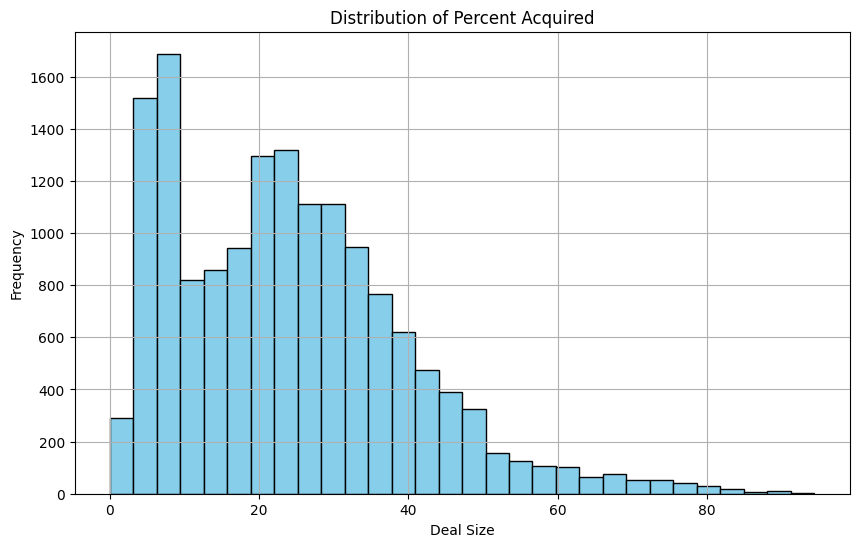

In [25]:
# graph results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df["PercentAcquired"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Deal Size')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Acquired')
plt.grid(True)
plt.show()

In [22]:
# now we finetune for funding round. Iterate through seedtypes and get distribution of error from real values using this approach
seedTypes = ['None','Seed','A', 'B', 'C', 'D','E', 'F', 'G']

for seed in seedTypes:
    if seed == 'None':
        dfA = df
    else:
        dfA = df[df["SeedType"] == seed]
    mean = dfA["PercentAcquired"].mean()
    dfA = dfA.dropna(subset=["FundPA" , "InvestorInvestmentAmount", "DealSize"])
    dfA["PredictedAVG"] =  (dfA["InvestorInvestmentAmount"]/dfA["DealSize"]) * mean
    print("Distribution of Error using Series ", seed, "Average")
    dfA["AVG_error"] =  (dfA["PredictedAVG"] - dfA["FundPA"]).abs()
    #   print(mean)
    print(dfA["AVG_error"].describe())

Distribution of Error using Series  None Average
count    1559.000000
mean        3.650690
std        16.640181
min         0.000171
25%         0.419432
50%         1.291993
75%         3.872300
max       620.601604
Name: AVG_error, dtype: float64
Distribution of Error using Series  Seed Average
count    64.000000
mean      2.475401
std       3.960029
min       0.008655
25%       0.372738
50%       1.148493
75%       2.511020
max      23.678029
Name: AVG_error, dtype: float64
Distribution of Error using Series  A Average
count    401.000000
mean       3.532348
std        5.030415
min        0.001987
25%        0.383748
50%        1.599647
75%        4.714266
max       39.340301
Name: AVG_error, dtype: float64
Distribution of Error using Series  B Average
count    298.000000
mean       2.185808
std        3.037347
min        0.001618
25%        0.351099
50%        1.041111
75%        2.770881
max       22.210651
Name: AVG_error, dtype: float64
Distribution of Error using Series  C Aver

/var/folders/f7/8j3xs5s170n8xsjr45rg2bzm0000gn/T/ipykernel_25539/3418971306.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA["PredictedAVG"] =  (dfA["InvestorInvestmentAmount"]/dfA["DealSize"]) * mean
/var/folders/f7/8j3xs5s170n8xsjr45rg2bzm0000gn/T/ipykernel_25539/3418971306.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA["AVG_error"] =  (dfA["PredictedAVG"] - dfA["FundPA"]).abs()


In [22]:
conn.close()